# **Import Libraries**

In [ ]:
import random
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import MaxAbsScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score

In [ ]:
! ls -la output.db

-rw-r--r-- 1 root root 1351680 Jun 22 17:37 output.db


# **Get Data**

In [ ]:
#Populate dataframe for each %TL (5,10,15,20)
data = "output.db"
conn = sqlite3.connect(data)

df_5 = pd.read_sql_query(
    """ SELECT  mzn, dzn,
                p5_conflicts, 
                p5_ewma_conflicts,
                p5_decision_level_engine,
   	            p5_ewma_decision_level_engine,
                p5_nodes,
                p5_ewma_opennodes,
                p5_vars,
                p5_back_jumps,
                p5_ewma_back_jumps,
                p5_solutions,
                p5_total_time,
                p5_search_time,
                p5_intVars,
                p5_propagations,
                p5_ewma_propagations,
                p5_propagators,
                p5_boolVars,
                p5_learnt ,
                p5_bin,
                p5_tern,
                p5_long_vars,
                p5_peak_depth,
                p5_best_objective,
                p5_ewma_best_objective,
                solved_within_time_limit
        FROM  features""", conn)

df_10 = pd.read_sql_query(
    """ SELECT  mzn, dzn,
                p10_conflicts, 
                p10_ewma_conflicts,
                p10_decision_level_engine,
   	            p10_ewma_decision_level_engine,
                p10_nodes,
                p10_ewma_opennodes,
                p10_vars,
                p10_back_jumps,
                p10_ewma_back_jumps,
                p10_solutions,
                p10_total_time,
                p10_search_time,
                p10_intVars,
                p10_propagations,
                p10_ewma_propagations,
                p10_propagators,
                p10_boolVars,
                p10_learnt ,
                p10_bin ,
                p10_tern ,
                p10_long_vars,
                p10_peak_depth,
                p10_best_objective,
                p10_ewma_best_objective,
                solved_within_time_limit
        FROM  features""", conn)

df_15 = pd.read_sql_query(
    """ SELECT  mzn, dzn,
                p15_conflicts, 
                p15_ewma_conflicts,
                p15_decision_level_engine,
   	            p15_ewma_decision_level_engine,
                p15_nodes,
                p15_ewma_opennodes,
                p15_vars,
                p15_back_jumps,
                p15_ewma_back_jumps,
                p15_solutions,
                p15_total_time,
                p15_search_time,
                p15_intVars,
                p15_propagations,
                p15_ewma_propagations,
                p15_propagators,
                p15_boolVars,
                p15_learnt ,
                p15_bin ,
                p15_tern ,
                p15_long_vars,
                p15_peak_depth,
                p15_best_objective,
                p15_ewma_best_objective,
                solved_within_time_limit
        FROM  features""", conn)

df_20 = pd.read_sql_query(
    """ SELECT  mzn, dzn,
                p20_conflicts, 
                p20_ewma_conflicts,
                p20_decision_level_engine,
   	            p20_ewma_decision_level_engine,
                p20_nodes,
                p20_ewma_opennodes,
                p20_vars,
                p20_back_jumps,
                p20_ewma_back_jumps,
                p20_solutions,
                p20_total_time,
                p20_search_time,
                p20_intVars,
                p20_propagations,
                p20_ewma_propagations,
                p20_propagators,
                p20_boolVars,
                p20_learnt ,
                p20_bin ,
                p20_tern ,
                p20_long_vars,
                p20_peak_depth,
                p20_best_objective,
                p20_ewma_best_objective,
                solved_within_time_limit
        FROM  features""", conn)

#Clean up dataframes structure
df_list  = [df_5, df_10, df_15, df_20]
new_cols = [    "failures", 
                "ewma_failures",
                "decisionLevel",
                "decisionLevel_ewma",
                "nodes",
                "ewma_opennodes",
                "vars",
                "back_jumps",
                "ewma_back_jumps",
                "solutions",
                "total_time",
                "search_time", #total time - init time
                "intVars",
                "propagations",
                "ewma_propagations",
                "propagators",
                "boolVars",
                "learnt" ,
                "bin",
                "tern",
                "long_vars",
                "peak_depth",
                "best_objective",
                "ewma_best_objective",
                "solved_within_time_limit"] 

for df in df_list:
    df["mzn"] = df.mzn.str.split('/').str[-1]             #shorten to filename
    df["dzn"] = df.dzn.str.split('/').str[-1]
    df.set_index(["mzn","dzn"], drop=True, inplace=True)  #set index to problem instance and data used
    df.columns = new_cols                                 #make column names of dfs identical                 
    df.fillna(0, inplace =True)                           #replace Nans in best_objective and ewma_best_objective


In [ ]:
#Calculate additonal features
time_out = 7200 #time in s (or 2hrs)
time_diff = 0.05*time_out

#combined features
for df in df_list:
  df["unassnVar"]   = (2^df.vars) - df.nodes
  df["fracFailUnassn"]     = df.failures / df.unassnVar         # num failures/ num open nodes
  df["fracOpenVisit"]  = (df.vars - df.nodes) / df.nodes       # ratio of open nodes to visited nodes (how much of soln space explored)
  df["fracBoolVars"]     = df.boolVars / df.vars                 # num bools / total num of vars
  df["fracPropVars"]     = df.propagations / df.vars        # num propagations/ total num of vars
  df["frac_unassigned"] = df.unassnVar / df.vars  # current assignments/ total vars
  df["fracLongClauses"] = df.long_vars / (df.long_vars + df.bin + df.tern)         # fraction of learnt clauses that have more than 3 literals
  df["freqBackjumps"]  = df.back_jumps/df.search_time
  df.fillna(0, inplace =True)  


#global rate of change features
G_roc_best_objective = [ (df_10.best_objective - df_5.best_objective)/time_diff,
                           (df_15.best_objective - df_10.best_objective)/time_diff,                 
                           (df_20.best_objective - df_15.best_objective)/time_diff]

G_roc_nodes = [ (df_10.nodes - df_5.nodes)/time_diff,
                    (df_15.nodes - df_10.nodes)/time_diff,                 
                    (df_20.nodes - df_15.nodes)/time_diff] 

G_roc_failures = [ (df_10.failures - df_5.failures)/time_diff,
                    (df_15.failures - df_10.failures)/time_diff,                 
                    (df_20.failures - df_15.failures)/time_diff] 

G_roc_backjumps = [ (df_10.back_jumps - df_5.back_jumps)/time_diff,
                    (df_15.back_jumps - df_10.back_jumps)/time_diff,                 
                    (df_20.back_jumps - df_15.back_jumps)/time_diff]

G_roc_propagations = [ (df_10.propagations- df_5.propagations)/time_diff,
                    (df_15.propagations - df_10.propagations)/time_diff,                 
                    (df_20.propagations - df_15.propagations)/time_diff]  

G_roc_solutions = [ (df_10.solutions - df_5.solutions)/time_diff,
                    (df_15.solutions - df_10.solutions)/time_diff,                 
                    (df_20.solutions - df_15.solutions)/time_diff]   
'''
G_roc_restarts = [ (df_10.restarts - df_5.restarts)/time_diff,
                    (df_15.restarts - df_10.restarts)/time_diff,                 
                    (df_20.restarts - df_15.restarts)/time_diff]                                                                              
'''


# add glbal rate of change features to dfs
count = 0
for k in [df_10, df_15, df_20]:
  k["objectiveGROC"] = G_roc_best_objective[count]
  k["nodesGROC"] = G_roc_nodes[count]
  k["failureGROC"] = G_roc_failures[count]
  k["backjumpsGROC"] = G_roc_backjumps[count]
  k["propagationsGROC"] = G_roc_propagations[count]
  k["solutionsGROC"] = G_roc_solutions[count]
  count = count + 1




# **Data Analysis**

In [ ]:
#distribution of classes
print("Solved | # Problems")
print(df_5["solved_within_time_limit"].value_counts()) 

Solved | # Problems
0    411
1     33
Name: solved_within_time_limit, dtype: int64


In [ ]:
#magintude of variables
df_5.describe()

,failures,ewma_failures,decisionLevel,decisionLevel_ewma,nodes,ewma_opennodes,vars,back_jumps,ewma_back_jumps,solutions,total_time,search_time,intVars,propagations,ewma_propagations,propagators,boolVars,learnt,bin,tern,long_vars,peak_depth,best_objective,ewma_best_objective,solved_within_time_limit,unassnVar,fracFailUnassn,fracOpenVisit,fracBoolVars,fracPropVars,frac_unassigned,fracLongClauses,freqBackjumps
count,4.440000e+02,444.0,444.000000,444.000000,4.440000e+02,4.440000e+02,4.440000e+02,4.440000e+02,444.000000,444.000000,444.000000,444.000000,4.440000e+02,4.440000e+02,4.440000e+02,444.000000,4.440000e+02,444.000000,4.440000e+02,4.440000e+02,444.000000,444.000000,4.440000e+02,4.440000e+02,444.000000,4.440000e+02,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000
mean,8.823726e+05,0.0,160.304054,168.452703,1.311363e+06,4.873287e+05,4.886545e+05,4.194462e+05,13.024775,59.461712,356.076421,355.296588,8.960459e+03,4.763165e+08,1.194165e+04,3754.641892,4.796921e+05,69755.864865,1.057711e+05,1.030385e+04,839.713964,232.450450,2.708440e+06,2.646197e+06,0.074324,-8.227093e+05,-0.664269,470.289507,0.970187,12700.524593,-115.914683,0.088950,1169.692996
std,7.216831e+05,0.0,314.955929,315.463341,8.931534e+05,2.269568e+06,2.269494e+06,6.289016e+05,7.530934,162.918517,23.317777,24.374020,8.233231e+04,6.154543e+08,2.381151e+05,20256.067627,2.250679e+06,23008.652795,7.534950e+05,8.300613e+04,3300.987458,461.908437,3.760589e+07,3.703441e+07,0.262594,2.625730e+06,1.202400,9136.410023,0.041011,28592.790264,952.767842,0.238966,1755.564129
min,0.000000e+00,0.0,2.000000,2.000000,3.000000e+00,2.330000e+02,2.420000e+02,0.000000e+00,0.000000,0.000000,10.711000,7.468000,3.700000e+01,0.000000e+00,0.000000e+00,1.000000,2.000000e+02,0.000000,0.000000e+00,0.000000e+00,0.000000,2.000000,-1.000000e+00,0.000000e+00,0.000000,-3.775847e+06,-7.623364,-0.999929,0.826446,0.000000,-14170.644628,0.000000,0.000000
25%,2.668788e+05,0.0,17.000000,24.000000,5.147762e+05,2.401600e+04,2.402275e+04,1.125650e+04,6.750000,0.000000,358.976500,358.482500,2.560000e+02,4.352989e+07,2.300000e+01,311.000000,2.323050e+04,58062.250000,0.000000e+00,0.000000e+00,0.000000,31.000000,0.000000e+00,0.000000e+00,0.000000,-1.877871e+06,-1.011145,-0.984127,0.970409,544.200311,-61.999260,0.000000,32.196547
50%,7.189140e+05,0.0,49.000000,56.500000,1.279628e+06,6.434850e+04,6.521950e+04,1.218860e+05,14.500000,7.500000,359.502000,359.344500,9.010000e+02,2.672571e+08,6.550000e+01,818.000000,6.301000e+04,73638.500000,1.713000e+03,3.100000e+01,0.000000,76.000000,6.050000e+01,2.250000e+01,0.000000,-1.109032e+06,-0.833261,-0.941042,0.987734,3276.678048,-15.967424,0.000000,339.036462
75%,1.332234e+06,0.0,180.000000,191.250000,1.937326e+06,2.337595e+05,2.342430e+05,5.307382e+05,19.000000,42.000000,359.848250,359.791750,2.207000e+03,6.302065e+08,1.912500e+02,3992.000000,2.320352e+05,86212.000000,2.731275e+04,2.192000e+03,567.750000,332.250000,1.778500e+03,1.279000e+03,0.000000,-3.976152e+05,-0.318997,-0.754050,0.993475,12836.807771,-3.065896,0.020257,1480.130476
max,3.444606e+06,0.0,4678.000000,4694.000000,3.784282e+06,2.457363e+07,2.457364e+07,3.203374e+06,63.000000,1440.000000,359.962000,359.962000,1.210447e+06,4.433095e+09,5.016705e+06,407885.000000,2.457352e+07,99998.000000,1.071509e+07,1.226225e+06,42861.000000,6423.000000,7.079651e+08,6.945451e+08,1.000000,2.453439e+07,17.108414,192327.333333,0.999995,324514.721676,0.999998,1.000000,9224.368148


In [ ]:
pd.options.display.max_columns = 999
df_5.loc[df_5.solved_within_time_limit ==1]

failures  ewma_failures  \
mzn                       dzn                                               
open_stacks_01.mzn        problem_40_20_1.dzn       340427              0   
                          problem_15_30_1.dzn       327558              0   
                          Miller19.dzn              243652              0   
pattern_set_mining.mzn    hypothyroid-k1.dzn         47649              0   
bus_scheduling.mzn        r1.dzn                    140060              0   
                          r1a.dzn                   124869              0   
pattern_set_mining.mzn    yeast-k2.dzn              146324              0   
                          kr-vs-kp-k2.dzn            27340              0   
pattern_set_mining_k2.mzn anneal.dzn                184619              0   
                          segment.dzn                72961              0   
                          vehicle.dzn               240016              0   
                          hepatitis.dzn             477619              0   
                          hypothyroid.dzn            57288              0   
                          yeast.dzn                 139919              0   
                          ionosphere.dzn            362623              0   
pattern_set_mining_k1.mzn hypothyroid.dzn            47226              0   
pattern_set_mining_k2.mzn sonar.dzn                 270028              0   
                          kr-vs-kp.dzn               26992              0   
pattern_set_mining_k1.mzn ionosphere.dzn             46194              0   
pattern_set_mining_k2.mzn german-credit.dzn         110274              0   
                          vowel.dzn                 228183              0   
pattern_set_mining_k1.mzn vehicle.dzn                85278              0   
                          yeast.dzn                 144532              0   
                          german-credit.dzn          87203              0   
                          sonar.dzn                  73255              0   
                          kr-vs-kp.dzn               25254              0   
train.mzn                 instance.15.dzn           153193              0   
                          instance.3.dzn            128519              0   
                          instance.4.dzn            132212              0   
macc.mzn                  307.dzn                    80946              0   
city-position.mzn         city-8-06.dzn             104550              0   
mznc2017_aes_opt.mzn      r8.dzn                    555383              0   
crossword_opt.mzn         grid-05.04_dict-80.dzn    256901              0   

                                                  decisionLevel  \
mzn                       dzn                                     
open_stacks_01.mzn        problem_40_20_1.dzn                 5   
                          problem_15_30_1.dzn                13   
                          Miller19.dzn                       11   
pattern_set_mining.mzn    hypothyroid-k1.dzn                 11   
bus_scheduling.mzn        r1.dzn                            407   
                          r1a.dzn                           750   
pattern_set_mining.mzn    yeast-k2.dzn                       14   
                          kr-vs-kp-k2.dzn                    13   
pattern_set_mining_k2.mzn anneal.dzn                         16   
                          segment.dzn                        11   
                          vehicle.dzn                        13   
                          hepatitis.dzn                      11   
                          hypothyroid.dzn                     9   
                          yeast.dzn                          15   
                          ionosphere.dzn                      6   
pattern_set_mining_k1.mzn hypothyroid.dzn                    12   
pattern_set_mining_k2.mzn sonar.dzn                          18   
                          kr-vs-kp.dzn                       17   
pattern_set_mi

In [ ]:
#Data pre-processing
for df in df_list:
    df.drop(df.columns[df.nunique() == 1], axis=1, inplace=True) #drop cols with constant value
    #rescale data
    transformer = MaxAbsScaler().fit(df)
    df = pd.DataFrame(transformer.transform(df), columns=df.columns, index=df.index) #normalise data

In [ ]:
features_list = df_list[3].nodes

# **Train Test Split**

In [ ]:
# training-testing split
X_train_5, X_test_5, y_train_5, y_test_5  = train_test_split(df_5.drop(columns = ["solved_within_time_limit"]),\
                                                     df_5["solved_within_time_limit"], test_size=0.25, random_state=22)

X_train_10, X_test_10, y_train_10, y_test_10  = train_test_split(df_10.drop(columns = ["solved_within_time_limit"]),\
                                                     df_10["solved_within_time_limit"], test_size=0.25, random_state=22)

X_train_15, X_test_15, y_train_15, y_test_15  = train_test_split(df_15.drop(columns = ["solved_within_time_limit"]),\
                                                     df_15["solved_within_time_limit"], test_size=0.25, random_state=22)

X_train_20, X_test_20, y_train_20, y_test_20  = train_test_split(df_20.drop(columns = ["solved_within_time_limit"]),\
                                                     df_20["solved_within_time_limit"], test_size=0.25, random_state=22)
#X_train, y_train, X_test, y_test  = df_5.drop(columns = ["solved_within_time_limit"]), df_5[["solved_within_time_limit"]],\
#df_5.drop(columns = ["solved_within_time_limit"]), df_5[["solved_within_time_limit"]]
#y_train= np.ravel(y_train)
#y_test= np.ravel(y_test)

In [ ]:
y_test_5.value_counts()

0    105
1      6
Name: solved_within_time_limit, dtype: int64

In [ ]:
y_train_5.value_counts()

0    306
1     27
Name: solved_within_time_limit, dtype: int64

In [ ]:
print(121/127)
print(353/380)

0.952755905511811
0.9289473684210526


# **Import Models**

In [ ]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['LR'] = LogisticRegression(max_iter=1000, C=1000 , class_weight = 'balanced',random_state=22)

#Support Vector Machine
from sklearn.svm import SVC
models['SVM'] = SVC(kernel = 'rbf', class_weight = 'balanced', probability = True, random_state=22)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['RF'] = RandomForestClassifier(min_samples_leaf = 5, class_weight = 'balanced_subsample',random_state=22)

#Extra Tree
from sklearn.ensemble import ExtraTreesClassifier
models['ET'] = ExtraTreesClassifier(class_weight = 'balanced', random_state=22)

#Multi-layered perceptron
from sklearn.neural_network import MLPClassifier
models['MLP'] = MLPClassifier(random_state=22)

# Naive Bayes
#from sklearn.naive_bayes import GaussianNB
#models['NB'] = GaussianNB()

# Adaboost
#from sklearn.ensemble import AdaBoostClassifier
#models['AB'] = AdaBoostClassifier()

#KNN
#from sklearn.neighbors import KNeighborsClassifier
#models['KNN'] = KNeighborsClassifier(weights = 'distance')

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['DT'] = DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced', random_state=22)

#Dummy classifier
from sklearn.dummy import DummyClassifier
models['DUM'] = DummyClassifier(strategy="most_frequent")

# **Feature Importance Analysis**

Feature importance for all features

Large error bars may result from Gini Importance being misleading when features have many unique values 



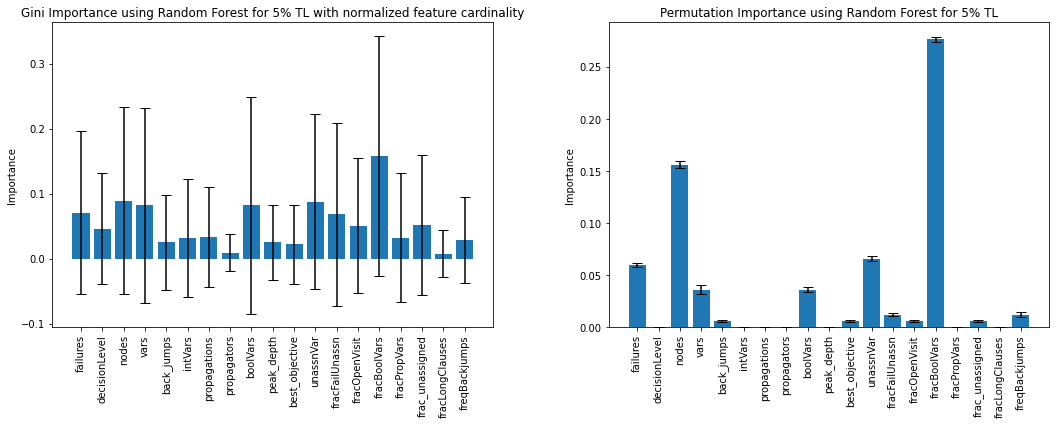

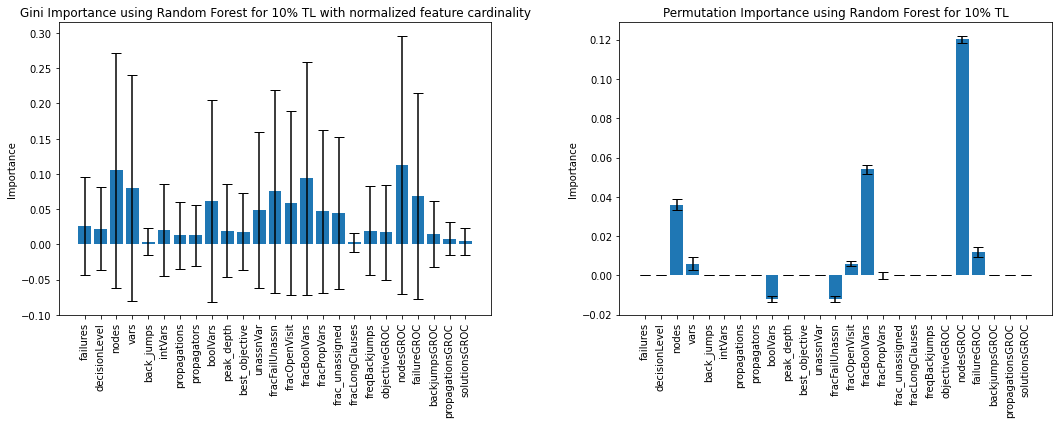

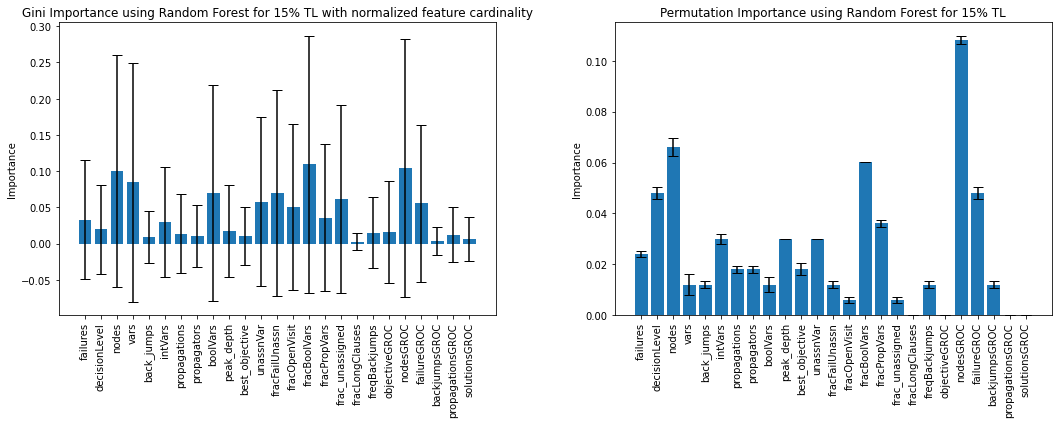

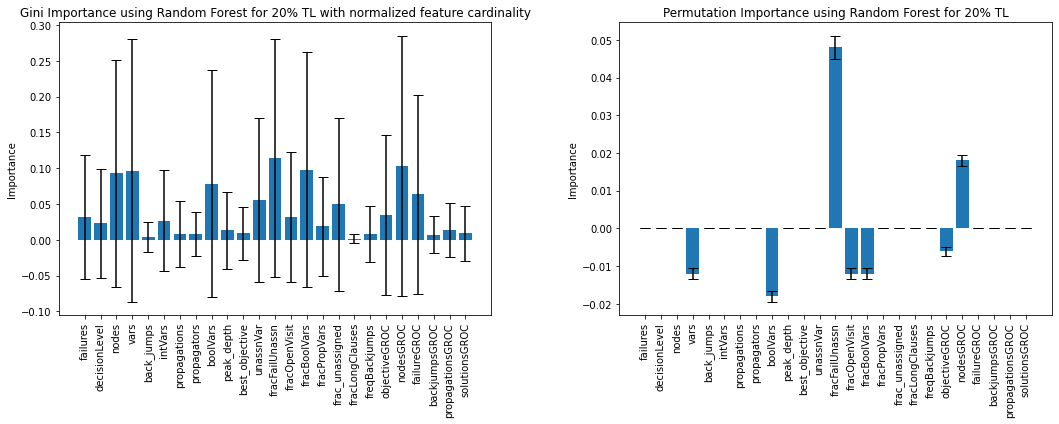

In [ ]:
def feat_import_plt(X, y, perc_TL):
  #Display Flags 
  ordered = False   #True displays importances in descending order
  errorbar = True
  cardinality = False

  #Drop values that are neither standard chuffed values nor created
  X.drop([      
                "solutions",
                "total_time",
                "search_time", #total time - init time
                "learnt" ,
                "bin",
                "tern",
                "long_vars",
                "ewma_opennodes",
                "decisionLevel_ewma",
                "ewma_back_jumps",
                "ewma_propagations",
                "ewma_best_objective"], axis=1, inplace=True)
  

  #Feature importance using Gini Impurity
  dcs_t = RandomForestClassifier(min_samples_leaf = 5,random_state=22)
  dcs_t.fit(X, y)

  importances = dcs_t.feature_importances_
  std = np.std([tree.feature_importances_ for tree in dcs_t.estimators_], axis=0) #get standard dev of importances

  if ordered:
    _sorted_indices = np.argsort(importances)[::-1]   # Sort the feature importance in descending order
  else:
    _sorted_indices = np.array(range(len(importances)))   # unsorted feature importances for comparison

  plt.figure(figsize=(15, 6))
  ax1 = plt.subplot(1, 2, 1)
  plt.title('Gini Importance using Random Forest for '+ perc_TL+'% TL with normalized feature cardinality')
  if not errorbar:
    ax1.bar(range(X.shape[1]), importances[_sorted_indices])
  else :
    ax1.bar(range(X.shape[1]), importances[_sorted_indices], yerr=std, ecolor='black', capsize=5, align='center')
  ax1.set_ylabel('Importance')
  plt.xticks(range(X.shape[1]), X.columns[_sorted_indices], rotation=90)

  #print("GI:", importances[sorted_indices])

  if cardinality:
    c = df_5.apply(pd.Series.nunique) #feature cardinality
    c_array = []
    for i in X.columns[_sorted_indices]:
      c_array.append(c.loc[i]/ max(df_5.apply(pd.Series.nunique).values))
    
    ax2 = ax1.twinx()
    ax2.plot(range(X.shape[1]), c_array, color = 'r' )
    ax2.set_ylabel('Cardinality', color = 'r')

  #Feature importance using Permutation Importance
  perm = permutation_importance(dcs_t, X, y, random_state = 22)
  if ordered:
    _perm_sorted_indices = np.argsort(perm.importances_mean)[::-1] # Sort the feature importance in descending order
  else:
    _perm_sorted_indices = _sorted_indices

  ax3 = plt.subplot(1, 2, 2)
  plt.title('Permutation Importance using Random Forest for '+ perc_TL+'% TL')
  if not errorbar:
    ax3.bar(range(X.shape[1]), perm.importances_mean[_perm_sorted_indices]*10)
  else:
    ax3.bar(range(X.shape[1]), perm.importances_mean[_perm_sorted_indices]*10, yerr=perm.importances_std, ecolor='black', capsize=5, align='center')
  plt.xticks(range(X.shape[1]), X.columns[_perm_sorted_indices], rotation=90)
  ax3.set_ylabel('Importance')

  #print("PI:", perm.importances_mean[perm_sorted_indices])

  if cardinality:
    c_array = []
    for i in X.columns[_perm_sorted_indices]:
      c_array.append(c.loc[i]/ max(df_5.apply(pd.Series.nunique).values))
    ax2 = ax3.twinx()
    ax2.plot(range(X.shape[1]), c_array, color = 'r' )
    ax2.set_ylabel('Cardinality', color = 'r')

  #plt.subplot(1, 3, 3)
  #sns.heatmap(X.corr(), mask = np.triu(X.corr()) )


  plt.tight_layout()
  plt.show()

print("Large error bars may result from Gini Importance being misleading when features have many unique values \n")
feat_import_plt(X_train_5, y_train_5,  "5")
feat_import_plt(X_train_10, y_train_10, "10")
feat_import_plt(X_train_15, y_train_15,  "15")
feat_import_plt(X_train_20, y_train_20,  "20")

Feature importance for proposed (or created) features

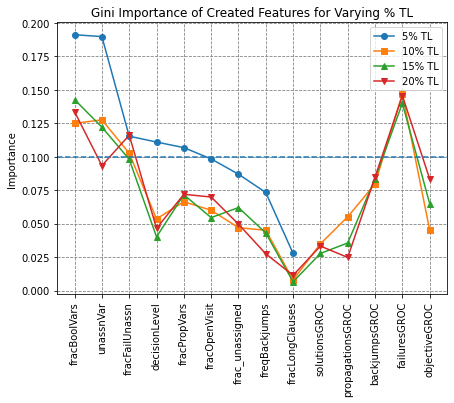

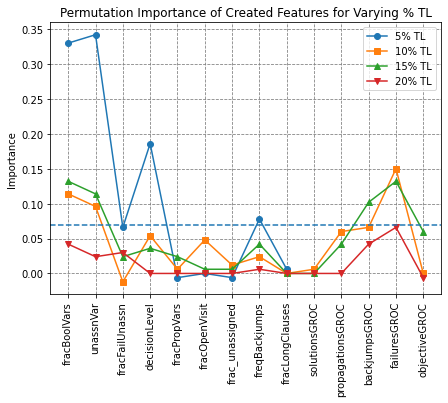

In [ ]:
#Only keep proposed features
for df in df_list:
  df.drop([    "failures", 
                "nodes",
                "ewma_opennodes",
                "decisionLevel_ewma",
                "vars",
                "back_jumps",
                "ewma_back_jumps",
                "solutions",
                "total_time",
                "search_time", #total time - init time
                "intVars",
                "propagations",
                "ewma_propagations",
                "propagators",
                "boolVars",
                "learnt" ,
                "bin",
                "tern",
                "long_vars",
                "peak_depth",
                "best_objective",
                "ewma_best_objective"], axis=1, inplace=True)
  
  
  
#dummy vars for df_5 to match size of other dfs
df_5["objectiveGROC"] = np.zeros(df_5.shape[0])
df_5["failuresGROC"] = np.zeros(df_5.shape[0])
df_5["backjumpsGROC"] = np.zeros(df_5.shape[0])
df_5["propagationsGROC"] = np.zeros(df_5.shape[0])
df_5["solutionsGROC"] = np.zeros(df_5.shape[0])


# Resplit dats into training-testing 
Xd_train_5, Xd_test_5, yd_train_5, yd_test_5  = train_test_split(df_5.drop(columns = ["solved_within_time_limit"]),\
                                                     df_5["solved_within_time_limit"], test_size=0.25, random_state=22)

Xd_train_10, Xd_test_10, yd_train_10, yd_test_10  = train_test_split(df_10.drop(columns = ["solved_within_time_limit"]),\
                                                     df_10["solved_within_time_limit"], test_size=0.25, random_state=22)

Xd_train_15, Xd_test_15, yd_train_15, yd_test_15  = train_test_split(df_15.drop(columns = ["solved_within_time_limit"]),\
                                                     df_15["solved_within_time_limit"], test_size=0.25, random_state=22)

Xd_train_20, Xd_test_20, yd_train_20, yd_test_20  = train_test_split(df_20.drop(columns = ["solved_within_time_limit"]),\
                                                     df_20["solved_within_time_limit"], test_size=0.25, random_state=22)
#Feature importances using only proposed features
def importance (X, y):
  dcs_5 = RandomForestClassifier(min_samples_leaf = 5,random_state=22)
  dcs_5.fit(X, y)
  importances_5 = dcs_5.feature_importances_
  std_5 = np.std([tree.feature_importances_ for tree in dcs_5.estimators_], axis=0) #get standard dev of importances
  perm_5 = permutation_importance(dcs_5, X, y, random_state = 22)
  return importances_5, perm_5

[importances_5, perm_5] = importance(Xd_train_5, yd_train_5)
sorted_indices = np.argsort(importances_5)[::-1] 
perm_sorted_indices = np.argsort(perm_5.importances_mean)[::-1] 

[importances_10, perm_10] = importance(Xd_train_10, yd_train_10)
sorted_indices_10 = np.argsort(importances_10)[::-1] 
perm_sorted_indices_10 = np.argsort(perm_10.importances_mean)[::-1]

[importances_15, perm_15] = importance(Xd_train_15, yd_train_15)
sorted_indices_15 = np.argsort(importances_15)[::-1] 
perm_sorted_indices_15 = np.argsort(perm_15.importances_mean)[::-1] 

[importances_20, perm_20] = importance(Xd_train_20, yd_train_20)
sorted_indices_20 = np.argsort(importances_20)[::-1] 
perm_sorted_indices_20 = np.argsort(perm_20.importances_mean)[::-1] 

#Print images
printAll = True #set to flase to show top 10 features

if printAll:
  plt.figure(figsize=(7, 5))
  plt.title('Gini Importance of Created Features for Varying % TL')
  plt.plot(Xd_train_5.columns[sorted_indices][0:9], importances_5[sorted_indices][0:9],'-o' )
  plt.plot(Xd_train_10.columns[sorted_indices], importances_10[sorted_indices], '-s')
  plt.plot(Xd_train_15.columns[sorted_indices], importances_15[sorted_indices], '-^' )
  plt.plot(Xd_train_20.columns[sorted_indices], importances_20[sorted_indices], '-v')
  plt.axhline(y=0.10, linestyle='--')
  plt.xticks(range(Xd_train_5.shape[1]), Xd_train_5.columns[sorted_indices], rotation=90)
  plt.ylabel('Importance')
  plt.grid(axis='both', color='gray', linestyle='dashed')
  plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])

  plt.figure(figsize=(7, 5))
  plt.title('Permutation Importance of Created Features for Varying % TL')
  plt.plot(Xd_train_5.columns[sorted_indices][0:9], perm_5.importances_mean[sorted_indices][0:9]*10,'-o' )
  plt.plot(Xd_train_10.columns[sorted_indices], perm_10.importances_mean[sorted_indices]*10, '-s')
  plt.plot(Xd_train_15.columns[sorted_indices], perm_15.importances_mean[sorted_indices]*10, '-^' )
  plt.plot(Xd_train_20.columns[sorted_indices], perm_20.importances_mean[sorted_indices]*10, '-v')
  plt.axhline(y=0.07, linestyle='--')
  plt.xticks(range(Xd_train_5.shape[1]), Xd_train_5.columns[sorted_indices], rotation=90)
  plt.ylabel('Importance')
  plt.grid(axis='both', color='gray', linestyle='dashed')
  plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])
else:
  plt.figure(figsize=(7, 5))
  plt.title('Top 10 Gini Important Created Features for Varying % TL')
  plt.plot(Xd_train_5.columns[sorted_indices][0:10], importances_5[sorted_indices][0:10],'o' )
  plt.plot(Xd_train_10.columns[sorted_indices_10][0:10], importances_10[sorted_indices_10][0:10], 's')
  plt.plot(Xd_train_15.columns[sorted_indices_15][0:10], importances_15[sorted_indices_15][0:10], '^' )
  plt.plot(Xd_train_20.columns[sorted_indices_20][0:10], importances_20[sorted_indices_20][0:10], 'v')
  plt.axhline(y=0.10, linestyle='--')
  plt.xticks(range(13), Xd_train_5.columns[sorted_indices][0:12], rotation=90)
  plt.ylabel('Importance')
  plt.grid(axis='both', color='gray', linestyle='dashed')
  plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])

  plt.figure(figsize=(7, 5))
  plt.title('Top 10 Permutation Important Created Features for Varying % TL')
  plt.plot(Xd_train_5.columns[perm_sorted_indices][0:10], perm_5.importances_mean[perm_sorted_indices][0:10]*10,'o' )
  plt.plot(Xd_train_10.columns[perm_sorted_indices_10][0:10], perm_10.importances_mean[perm_sorted_indices_10][0:10]*10, 's')
  plt.plot(Xd_train_15.columns[perm_sorted_indices_15][0:10], perm_15.importances_mean[perm_sorted_indices_15][0:10]*10, '^' )
  plt.plot(Xd_train_20.columns[perm_sorted_indices_20][0:10], perm_20.importances_mean[perm_sorted_indices_20][0:10]*10, 'v')
  plt.axhline(y=0.07, linestyle='--')
  plt.xticks(range(13), Xd_train_5.columns[perm_sorted_indices][0:12], rotation=90)
  plt.ylabel('Importance')
  plt.grid(axis='both', color='gray', linestyle='dashed')
  plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])


In [ ]:
#select top 5 features for training
Xs_train_5  = Xd_train_5.iloc[:, sorted_indices[0:5]]
Xs_train_10 = Xd_train_10.iloc[:,sorted_indices_10[0:5]]
Xs_train_15 = Xd_train_15.iloc[:,sorted_indices_15[0:5]]
Xs_train_20 = Xd_train_20.iloc[:,sorted_indices_20[0:5]]

Xs_test_5  = Xd_test_5.iloc[:,sorted_indices[0:5]]
Xs_test_10 = Xd_test_10.iloc[:,sorted_indices_10[0:5]]
Xs_test_15 = Xd_test_15.iloc[:,sorted_indices_15[0:5]]
Xs_test_20 = Xd_test_20.iloc[:,sorted_indices_20[0:5]]

print("Top 5 features:",Xd_train_10.columns[sorted_indices_10][0:5])

Top 5 features: Index(['nodesGROC', 'unassnVar', 'fracBoolVars', 'fracFailUnassn',
       'failureGROC'],
      dtype='object')


# **Predictions and Evaluation**

In [ ]:
y_test_5

mzn                     dzn                   
celar.mzn               CELAR7-SUB3.dzn           0
neighbours-rect.mzn     neightbours-new-14.dzn    0
rcpsp_max.mzn           psp_c_314.dzn             0
train.mzn               instance.12.dzn           0
city-position.mzn       city-7-04.dzn             0
                                                 ..
amaze2.mzn              2012-04-20.dzn            0
carseq.mzn              car_73.dzn                0
amaze2.mzn              2012-04-23.dzn            0
carseq.mzn              car_78.dzn                0
rotating-workforce.mzn  Example789.dzn            0
Name: solved_within_time_limit, Length: 111, dtype: int64

In [ ]:
def results_plt(X_train, y_train, X_test, y_test, perc_TL):
  train_accuracy, accuracy, precision, recall, auc, f1 = {}, {}, {}, {}, {}, {}
  figs, axs = plt.subplots(1,6,figsize=(35, 5))

  for i, key in enumerate(models.keys()):

          # Fit the classifier model
          models[key].fit(X_train, y_train)

          # Prediction
          predictions = models[key].predict(X_test)
          predictions_prob = models[key].predict_proba(X_test)[:,1]
          train_predictions = models[key].predict(X_train)

          # Calculate Accuracy, Precision and Recall Metrics
          accuracy[key] = accuracy_score(predictions, y_test)
          precision[key] = precision_score(predictions, y_test, zero_division=1)
          recall[key] = recall_score(predictions, y_test, zero_division=1)
          auc[key] = roc_auc_score(y_test, predictions_prob)
          train_accuracy[key] = accuracy_score(train_predictions, y_train)
          f1[key] = f1_score(y_test,predictions)
          #should it be (true, pred)? yes
          
          #To Display
          RocCurveDisplay.from_predictions(y_test, predictions_prob, name=key , ax=axs[0])
          axs[1].bar(key, accuracy[key]) 
          axs[2].bar(key, train_accuracy[key]) 
          axs[3].bar(key, recall[key])
          axs[4].bar(key, precision[key])
          axs[5].bar(key, f1[key])

  axs[0].set_title("ROC Curve for "+perc_TL+"% TL")
  #axs[0].set_ylabel("Accuracy")

  axs[1].set_title("Test Accuracy for "+perc_TL+"% TL")
  axs[1].set_xticklabels(models.keys(),rotation=60)
  axs[1].set_ylabel("Accuracy")
  axs[1].grid(axis='y', color='gray', linestyle='dashed')

  axs[2].set_title("Train Accuracy for "+perc_TL+"% TL")
  axs[2].set_xticklabels(models.keys(),rotation=60)
  axs[2].set_ylabel("Accuracy")
  axs[2].grid(axis='y', color='gray', linestyle='dashed')

  axs[3].set_title("Recall for "+perc_TL+"% TL")
  axs[3].set_xticklabels(models.keys(),rotation=60)
  axs[3].set_ylabel("Recall")
  axs[3].grid(axis='y', color='gray', linestyle='dashed')


  axs[4].set_title("Precision "+perc_TL+"% TL")
  axs[4].set_xticklabels(models.keys(),rotation=60)
  axs[4].set_ylabel("F1")
  axs[4].grid(axis='y', color='gray', linestyle='dashed')

  axs[5].set_title("F1 "+perc_TL+"% TL")
  axs[5].set_xticklabels(models.keys(),rotation=60)
  axs[5].set_ylabel("F1")
  axs[5].grid(axis='y', color='gray', linestyle='dashed')
  figs.show()   

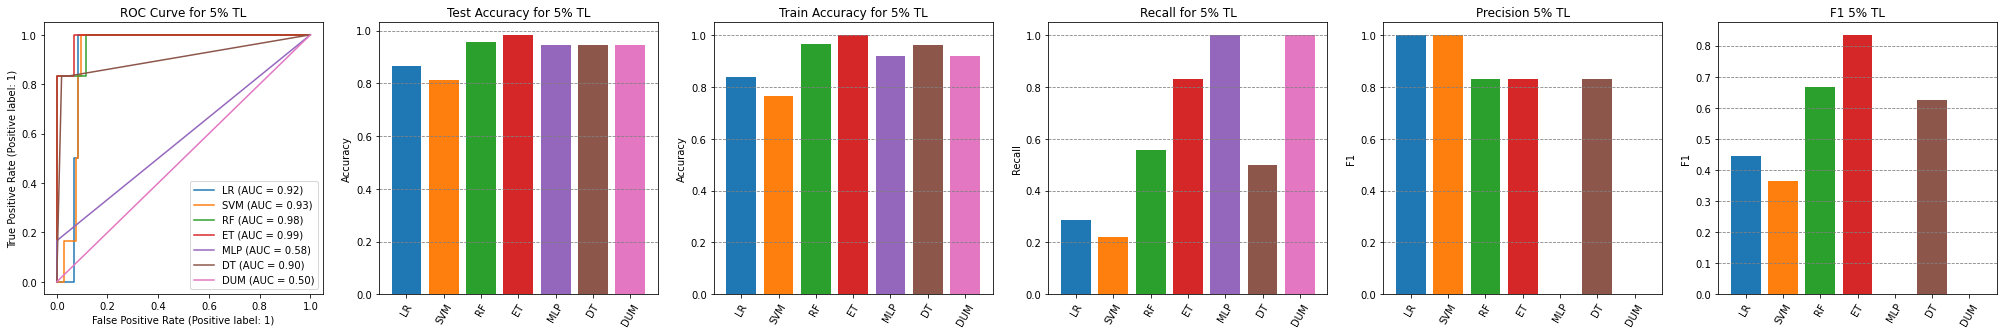

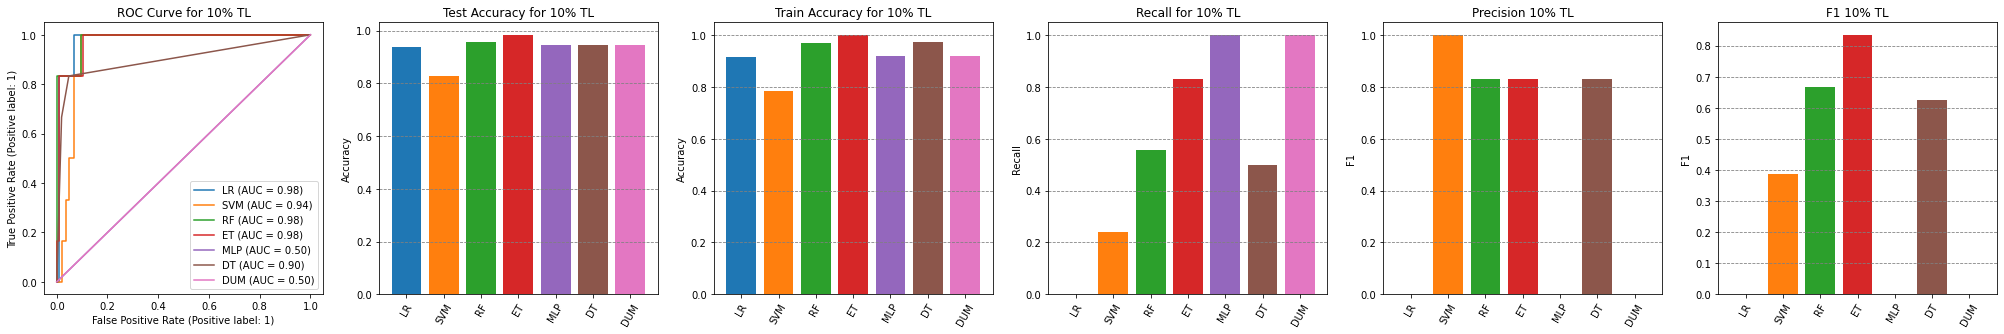

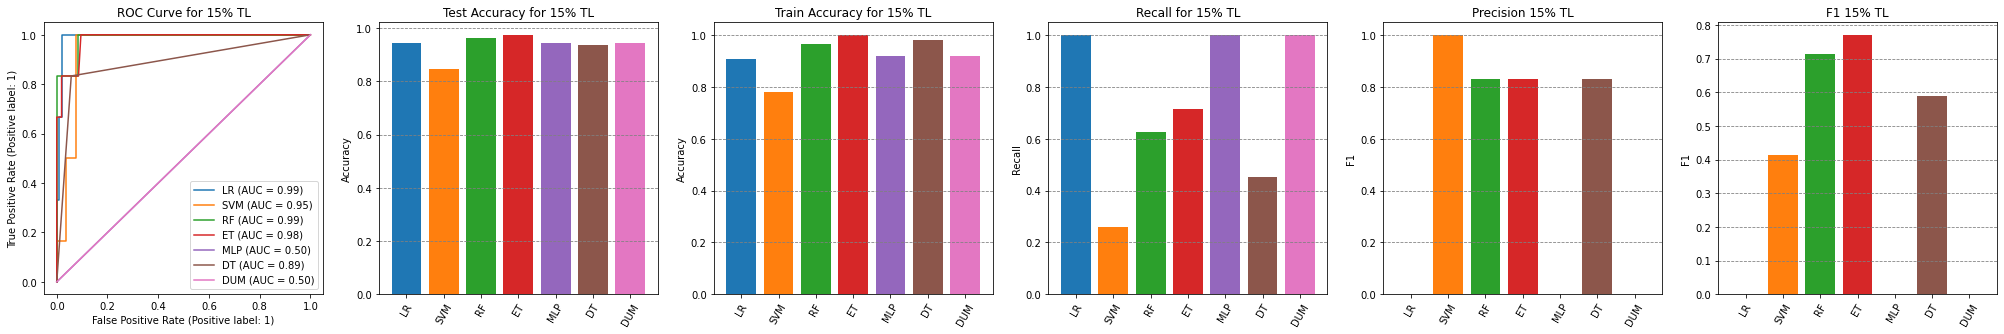

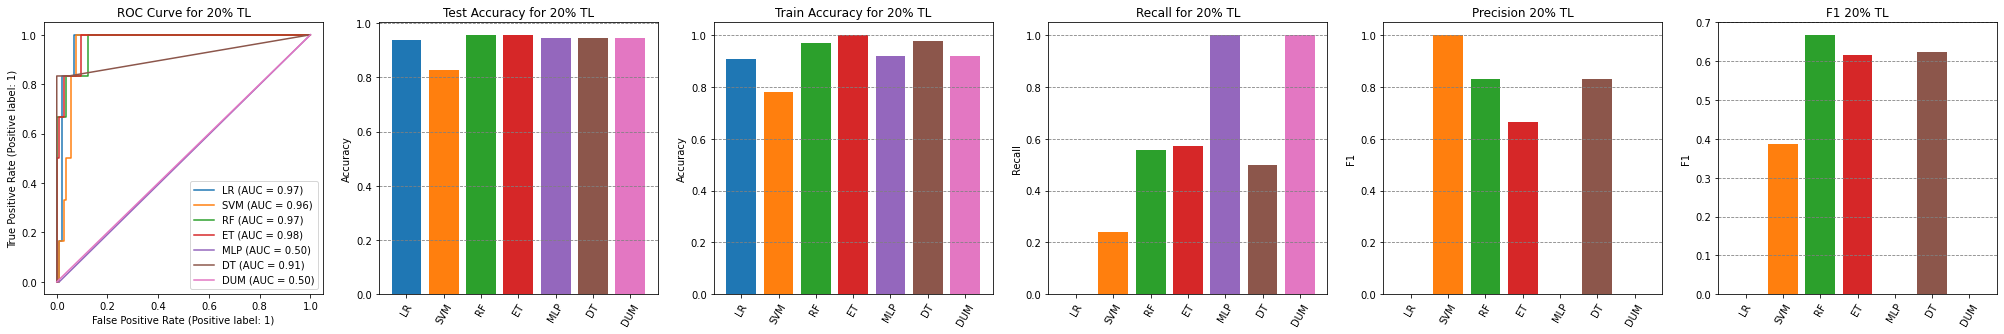

In [ ]:
#Bar plot results  for testing and training using top 5 created features
results_plt(Xs_train_5, yd_train_5, Xs_test_5, yd_test_5, "5")
results_plt(Xs_train_10, yd_train_10, Xs_test_10, yd_test_10, "10")
results_plt(Xs_train_15, yd_train_15, Xs_test_15, yd_test_15, "15")
results_plt(Xs_train_20, yd_train_20, Xs_test_20, yd_test_20, "20")

In [ ]:
def results_line_plt(X_train, y_train, X_test, y_test, perc_TL):
  train_accuracy, accuracy, precision, recall, auc, f1 = {}, {}, {}, {}, {}, {}
  #figs, axs = plt.subplots(1,6,figsize=(35, 5))

  for i, key in enumerate(models.keys()):

          # Fit the classifier model
          models[key].fit(X_train, y_train)

          # Prediction
          predictions = models[key].predict(X_test)
          predictions_prob = models[key].predict_proba(X_test)[:,1]
          train_predictions = models[key].predict(X_train)

          # Calculate Accuracy, Precision and Recall Metrics
          accuracy[key] = accuracy_score(predictions, y_test)
          precision[key] = precision_score(predictions, y_test, zero_division=1)
          recall[key] = recall_score(predictions, y_test, zero_division=1)
          auc[key] = roc_auc_score(y_test, predictions_prob)
          train_accuracy[key] = accuracy_score(train_predictions, y_train)
          f1[key] = f1_score(y_test,predictions)
          #should it be (true, pred)? yes
  print("\n------------------------------------------------------------------------")
  print(perc_TL+"% TL train acc:", np.round(list(train_accuracy.values()),2))
  print(perc_TL+"% TL test acc :", np.round(list(accuracy.values()),2))
  print(perc_TL+"% TL precision:",  np.round(list(precision.values()),2))
  print(perc_TL+"% TL recall   :",  np.round(list(recall.values()),2))
  print(perc_TL+"% TL F1       :",  np.round(list(f1.values()),2))
  print(perc_TL+"% TL ROC AUC  :",  np.round(list(auc.values()),2))
  print("------------------------------------------------------------------------")
  return train_accuracy, accuracy, precision, recall, auc, f1

  



------------------------------------------------------------------------
5% TL train acc: [0.84 0.77 0.97 1.   0.92 0.96 0.92]
5% TL test acc : [0.86 0.81 0.95 0.98 0.95 0.95 0.95]
5% TL precision: [1.   1.   0.83 0.83 0.   0.83 0.  ]
5% TL recall   : [0.29 0.22 0.56 0.83 1.   0.5  1.  ]
5% TL F1       : [0.44 0.36 0.67 0.83 0.   0.62 0.  ]
5% TL ROC AUC  : [0.92 0.93 0.98 0.99 0.58 0.9  0.5 ]
------------------------------------------------------------------------

------------------------------------------------------------------------
10% TL train acc: [0.92 0.78 0.97 1.   0.92 0.97 0.92]
10% TL test acc : [0.94 0.83 0.95 0.98 0.95 0.95 0.95]
10% TL precision: [0.   1.   0.83 0.83 0.   0.83 0.  ]
10% TL recall   : [0.   0.24 0.56 0.83 1.   0.5  1.  ]
10% TL F1       : [0.   0.39 0.67 0.83 0.   0.62 0.  ]
10% TL ROC AUC  : [0.98 0.94 0.98 0.98 0.5  0.9  0.5 ]
------------------------------------------------------------------------

---------------------------------------------------

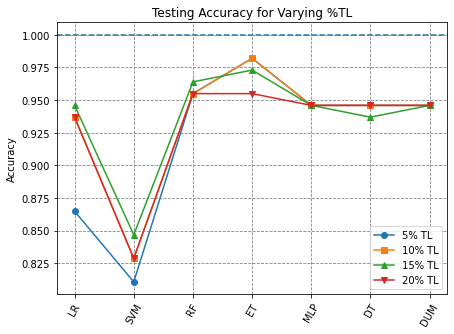

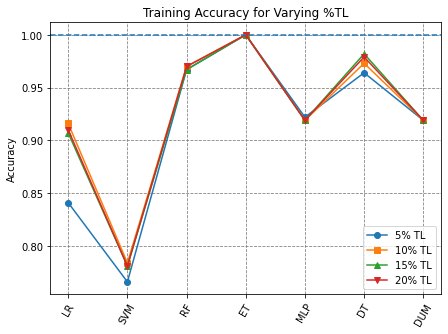

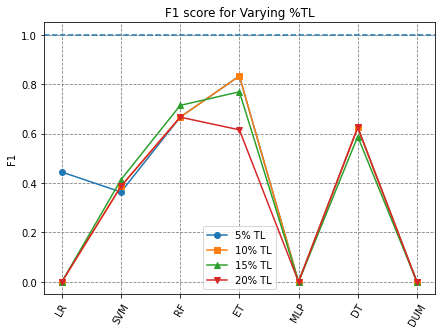

In [ ]:

#Line plot results  for testing and training using top 5 created features
train_accuracy_5, accuracy_5, precision_5, recall_5, auc_5, f1_5 = results_line_plt(Xs_train_5, yd_train_5, Xs_test_5, yd_test_5, "5")
train_accuracy_10, accuracy_10, precision_10, recall_10, auc_10, f1_10 = results_line_plt(Xs_train_10, yd_train_10, Xs_test_10, yd_test_10, "10")
train_accuracy_15, accuracy_15, precision_15, recall_15, auc_15, f1_15 = results_line_plt(Xs_train_15, yd_train_15, Xs_test_15, yd_test_15, "15")
train_accuracy_20, accuracy_20, precision_20, recall_20, auc_20, f1_20 = results_line_plt(Xs_train_20, yd_train_20, Xs_test_20, yd_test_20, "20")

plt.figure(figsize=(7, 5))
plt.title("Testing Accuracy for Varying %TL")
plt.plot(list(accuracy_5.keys()), list(accuracy_5.values()), '-o') 
plt.plot(list(accuracy_10.keys()), list(accuracy_10.values()), '-s') 
plt.plot(list(accuracy_15.keys()), list(accuracy_15.values()), '-^') 
plt.plot(list(accuracy_20.keys()), list(accuracy_20.values()), '-v') 
plt.axhline(y=1, linestyle='--')
plt.xticks(range(len(models)), models.keys(),rotation=60)
plt.ylabel('Accuracy')
plt.grid(axis='both', color='gray', linestyle='dashed')
plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])

plt.figure(figsize=(7, 5))
plt.title("Training Accuracy for Varying %TL")
plt.plot(list(train_accuracy_5.keys()), list(train_accuracy_5.values()),'-o') 
plt.plot(list(train_accuracy_10.keys()), list(train_accuracy_10.values()), '-s') 
plt.plot(list(train_accuracy_15.keys()), list(train_accuracy_15.values()), '-^') 
plt.plot(list(train_accuracy_20.keys()), list(train_accuracy_20.values()), '-v') 
plt.axhline(y=1, linestyle='--')
plt.xticks(range(len(models)), models.keys(),rotation=60)
plt.ylabel('Accuracy')
plt.grid(axis='both', color='gray', linestyle='dashed')
plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])

plt.figure(figsize=(7, 5))
plt.title("F1 score for Varying %TL")
plt.plot(list(f1_5.keys()), list(f1_5.values()),'-o') 
plt.plot(list(f1_10.keys()), list(f1_10.values()), '-s') 
plt.plot(list(f1_15.keys()), list(f1_15.values()), '-^') 
plt.plot(list(f1_20.keys()), list(f1_20.values()), '-v') 
plt.axhline(y=1, linestyle='--')
plt.xticks(range(len(models)), models.keys(),rotation=60)
plt.ylabel('F1')
plt.grid(axis='both', color='gray', linestyle='dashed')
plt.legend(["5% TL", "10% TL", "15% TL", "20% TL"])

plt.show() 

In [ ]:
rf_reg = RandomForestClassifier(min_samples_leaf = 5)
rf_reg.fit(X_train_20,y_train_20)
predictions=rf_reg.predict(X_test_20)
print('f1 score is', f1_score(y_test_20,predictions))


importances = rf_reg.feature_importances_

# Sort the feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance of Random Forest Regressor')
plt.bar(range(X_train_20.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train_20.shape[1]), X_train_20.columns[sorted_indices], rotation=90)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- bin
- decisionLevel_ewma
- ewma_back_jumps
- ewma_best_objective
- ewma_opennodes
- ...
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
#confusion_matrix(y_test_5,predictions)
plot_confusion_matrix(rf_reg, X_test_20, y_test_20)

In [ ]:
df_20.describe()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(min_samples_leaf = 5)
scores = cross_val_score(rf, df_20.drop('solved_within_time_limit', axis=1), df_20['solved_within_time_limit'], cv=5, scoring='f1')
scores

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score

skf = StratifiedKFold(n_splits=5, shuffle=True)
X = df_20.drop('solved_within_time_limit', axis=1)
y = df_20['solved_within_time_limit']
for train, test in skf.split(X, y):
    rf = RandomForestClassifier(min_samples_leaf = 5)
    rf.fit(X.iloc[train], y.iloc[train])
    pred = rf.predict(X.iloc[test])
    print(len(y.iloc[test][y == 1]))
    print(f1_score(y.iloc[test], pred))
    plot_confusion_matrix(rf, X.iloc[test], y.iloc[test])